In [1]:
import random
import gym
import numpy as np
from collections import deque
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [2]:
EPOCHS = 500
THRESHOLD = 45

In [3]:
class DQN():
    def __init__(self, env_string,batch_size=64):
        self.memory = deque(maxlen=100000)
        self.env = gym.make(env_string)
        input_size = self.env.observation_space.shape[0]
        action_size = self.env.action_space.n
        self.batch_size = batch_size
        self.gamma = 1.0
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        
        alpha=0.01
        alpha_decay=0.01
        
        # Init model
        self.model = Sequential()
        self.model.add(Dense(24, input_dim=input_size, activation='tanh'))
        self.model.add(Dense(48, activation='tanh'))
        self.model.add(Dense(action_size, activation='linear'))
        self.model.compile(loss='mse', optimizer=Adam(learning_rate=alpha))

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state, epsilon):
        if np.random.random() <= epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.model.predict(state, verbose=0))

    def preprocess_state(self, state):
        return np.reshape(state, [1, 4])

    def replay(self, batch_size):
        x_batch, y_batch = [], []
        minibatch = random.sample(self.memory, min(len(self.memory), batch_size))
        for state, action, reward, next_state, done in minibatch:
            y_target = self.model.predict(state, verbose=0)
            y_target[0][action] = reward if done else reward + self.gamma * np.max(self.model.predict(next_state, verbose=0)[0])
            x_batch.append(state[0])
            y_batch.append(y_target[0])
        
        self.model.fit(np.array(x_batch), np.array(y_batch), batch_size=len(x_batch), verbose=0)
        #epsilon = max(epsilon_min, epsilon_decay*epsilon) # decrease epsilon
       

    def train(self):
        scores = deque(maxlen=100)
        avg_scores = []
        

        for e in range(EPOCHS):
            state = self.env.reset()
            if e % 10 == 0:
                self.env.render()
            state = self.preprocess_state(state)
            done = False
            i = 0
            while not done:
                action = self.choose_action(state,self.epsilon)
                next_state, reward, done, _ = self.env.step(action)
                if e % 10 == 0:
                    self.env.render()
                next_state = self.preprocess_state(next_state)
                self.remember(state, action, reward, next_state, done)
                state = next_state
                self.epsilon = max(self.epsilon_min, self.epsilon_decay*self.epsilon) # decrease epsilon
                i += 1
                
            if e % 10 == 0:
                self.env.close()

            scores.append(i)
            mean_score = np.mean(scores)
            avg_scores.append(mean_score)
            print(f'Epoch number {e}')
            if mean_score >= THRESHOLD and e >= 10:
                print('Ran {} episodes. Solved after {} trials ✔'.format(e, e - 10))
                return avg_scores
            if e % 10 == 0:
                print('[Episode {}] - Mean survival time over last 10 episodes was {} ticks.'.format(e, mean_score))

            self.replay(self.batch_size)
        
        print('Did not solve after {} episodes 😞'.format(e))
        return avg_scores



In [ ]:
import gym
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from collections import deque

class DQN():
    def __init__(self, env):
        self.env = env
        self.memory = deque(maxlen=2000)
        
        self.gamma = 0.85
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.005
        self.tau = .125

        self.model = self.create_model()
        self.target_model = self.create_model()

    def create_model(self):
        model = Sequential()
        state_shape = self.env.observation_space.shape
        model.add(Dense(24, input_dim=state_shape[0], activation="relu"))
        model.add(Dense(48, activation="relu"))
        model.add(Dense(24, activation="relu"))
        model.add(Dense(self.env.action_space.n))
        model.compile(loss="mean_squared_error",
            optimizer=Adam(lr=self.learning_rate))
        return model

    def act(self, state):
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon_min, self.epsilon)
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.model.predict(state)[0])

    def remember(self, state, action, reward, new_state, done):
        self.memory.append([state, action, reward, new_state, done])

    def replay(self):
        batch_size = 32
        if len(self.memory) < batch_size: 
            return

        samples = random.sample(self.memory, batch_size)
        for sample in samples:
            state, action, reward, new_state, done = sample
            target = self.target_model.predict(state)
            if done:
                target[0][action] = reward
            else:
                Q_future = max(self.target_model.predict(new_state)[0])
                target[0][action] = reward + Q_future * self.gamma
            self.model.fit(state, target, epochs=1, verbose=0)

    def target_train(self):
        weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] = weights[i] * self.tau + target_weights[i] * (1 - self.tau)
        self.target_model.set_weights(target_weights)

    def train(self, episodes=1000, steps=200):
            rewards = []  # Initialize the rewards list
            for episode in range(episodes):
                cur_state = self.env.reset().reshape(1,2)
                episode_reward = 0  # Initialize the reward for this episode
                for step in range(steps):
                    action = self.act(cur_state)
                    new_state, reward, done, _ = self.env.step(action)
                    new_state = new_state.reshape(1,2)
                    self.remember(cur_state, action, reward, new_state, done)
                    self.replay()
                    self.target_train()
                    cur_state = new_state
                    episode_reward += reward  # Add the reward to the total reward for this episode
                    if done:
                        break
                rewards.append(episode_reward)  # Append the total reward for this episode to the rewards list


env = gym.make("Pendulum-v0")
dqn_agent = DQN(env=env)

rewards = dqn_agent.train(episodes=1000)

# Plot the rewards
plt.plot(rewards)
plt.title('Rewards per episode')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

In [7]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Flatten, Add
class DDPG():
    def __init__(self, env_string, batch_size=64):
        self.memory = deque(maxlen=100000)
        self.env = gym.make(env_string)
        state_size = self.env.observation_space.shape[0]
        action_size = self.env.action_space.shape[0]
        self.batch_size = batch_size
        self.gamma = 0.99
        self.tau = 0.001
        self.epsilon = 1.0  
        self.epsilon_decay = 0.995  
        self.epsilon_min = 0.01  

        # Actor Network
        self.actor_model = self.build_actor_model(state_size, action_size)
        self.target_actor_model = self.build_actor_model(state_size, action_size)
        self.target_actor_model.set_weights(self.actor_model.get_weights())

        # Critic Network
        self.critic_model = self.build_critic_model(state_size, action_size)
        self.target_critic_model = self.build_critic_model(state_size, action_size)
        self.target_critic_model.set_weights(self.critic_model.get_weights())

    def build_actor_model(self, state_size, action_size):
        model = Sequential()
        model.add(Dense(24, input_dim=state_size, activation='relu'))
        model.add(Dense(48, activation='relu'))
        model.add(Dense(action_size, activation='tanh'))  # Pendulum uses action range from -2 to 2
        model.compile(loss='mse', optimizer=Adam())
        return model

    def build_critic_model(self, state_size, action_size):
        state_input = Input(shape=(state_size,))
        state_hidden = Dense(24, activation='relu')(state_input)
        state_hidden = Dense(48)(state_hidden)

        action_input = Input(shape=(action_size,))
        action_hidden = Dense(48)(action_input)

        merged = Add()([state_hidden, action_hidden])
        merged_hidden = Dense(24, activation='relu')(merged)
        output = Dense(1, activation='linear')(merged_hidden)
        model = Model(inputs=[state_input, action_input], outputs=output)

        model.compile(optimizer=Adam(), loss='mse')
        return model

    def remember(self, state, action, reward, new_state, done):
        self.memory.append([state, action, reward, new_state, done])

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        samples = random.sample(self.memory, self.batch_size)

        for sample in samples:
            state, action, reward, new_state, done = sample
            target = self.target_critic_model.predict([state, action])
            if done:
                target[0][0] = reward
            else:
                Q_future = max(self.target_critic_model.predict([new_state, self.actor_model.predict(new_state)])[0])
                target[0][0] = reward + Q_future * self.gamma
            self.critic_model.fit([state, action], target, epochs=1, verbose=0)

        actor_target = self.actor_model.predict(state)
        self.actor_model.fit(state, actor_target, epochs=1, verbose=0)

    def target_train(self):
        actor_weights = self.actor_model.get_weights()
        actor_target_weights = self.target_actor_model.get_weights()
        for i in range(len(actor_weights)):
            actor_target_weights[i] = self.tau * actor_weights[i] + (1 - self.tau) * actor_target_weights[i]
        self.target_actor_model.set_weights(actor_target_weights)

        critic_weights = self.critic_model.get_weights()
        critic_target_weights = self.target_critic_model.get_weights()
        for i in range(len(critic_weights)):
            critic_target_weights[i] = self.tau * critic_weights[i] + (1 - self.tau) * critic_target_weights[i]
        self.target_critic_model.set_weights(critic_target_weights)

    def act(self, state):
        self.epsilon *= self.epsilon_decay
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        return self.actor_model.predict(state)
    
    def train(self, max_episodes=1000, max_steps=500):
        for episode in range(max_episodes):
            cur_state = self.env.reset().reshape(1, self.env.observation_space.shape[0])
            for step in range(max_steps):
                action = self.act(cur_state)
                action = action.reshape(1, self.env.action_space.shape[0])

                new_state, reward, done, _ = self.env.step(action)
                new_state = new_state.reshape(1, self.env.observation_space.shape[0])

                self.remember(cur_state, action, reward, new_state, done)
                self.replay()
                self.target_train()

                cur_state = new_state
                if done:
                    break


In [8]:
# import gym
# import matplotlib.pyplot as plt

# Instantiate the DDPG model
env_name = 'Pendulum-v0'
model = DDPG(env_name)

# Train the model
episodes = 100
model.train(max_episodes=episodes)

# Visualize the training progress
plt.plot(range(episodes), model.rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

1/1 [==============================] - 0s 96ms/step


C:\Users\hazem\AppData\Local\Temp\ipykernel_33560\715627137.py:66: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  target[0][0] = reward + Q_future * self.gamma



1/1 [==============================] - 0s 79ms/step


C:\Users\hazem\AppData\Local\Temp\ipykernel_33560\715627137.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  target[0][0] = reward


1/1 [==============================] - 0s 36ms/step


In [ ]:
# env_string = 'CartPole-v0'
# agent = DQN(env_string)
# scores = agent.train()

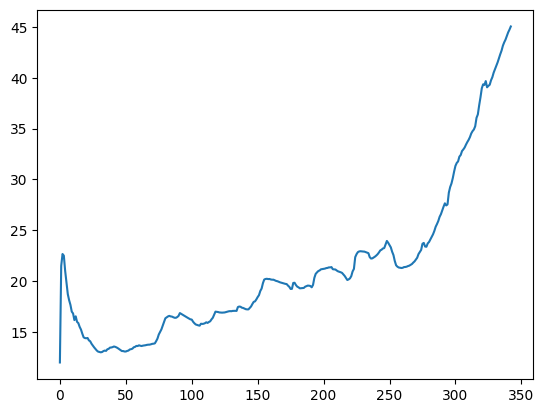

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                120       
                                                                 
 dense_1 (Dense)             (None, 48)                1200      
                                                                 
 dense_2 (Dense)             (None, 2)                 98        
                                                                 
Total params: 1418 (5.54 KB)
Trainable params: 1418 (5.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# plt.plot(scores)
# plt.show()
# agent.model.summary()
# agent.env.close()